In [1]:
#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim

import numpy as np
import pandas as pd
from model.Crossformer import *
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:

#DATASET 
ROOT_PATH = "data/DatasetClusters/fishes/fish02/"
DATA_PATH = "fish_02_pairs.csv"
#Device
DEVICE   = torch.device("cuda" if torch.cuda.is_available() else "cpu")



/cluster/home/abasine/.conda/envs/myenv/lib/python3.9/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 805: MPS client failed to connect to the MPS control daemon or the MPS server (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


# GLOBAL VARIABLES

In [3]:


STRIDE = 1
IN_LEN = 1031
OUT_LEN = 1031
PATCH_SIZE = 10

INDEX = ((1031 - IN_LEN ) // STRIDE) + 1
#INDEX = ((1031 - IN_LEN - OUT_LEN ) // STRIDE) + 1

NUM_PATHCES = int(IN_LEN / PATCH_SIZE)


In [4]:

j = 0
for i in range(0,INDEX,1):
    s_begin = i * STRIDE
    s_end = s_begin + IN_LEN
    r_begin = s_end
    r_end = r_begin + OUT_LEN
    
    #r_begin = s_begin
    #r_end = r_begin + OUT_LEN

    if s_begin > 1031:
        s_begin = 1031 - IN_LEN - OUT_LEN
        s_end = s_begin + IN_LEN
        r_begin = s_end
        r_end = r_begin + OUT_LEN
    j+=1
    print(s_begin,s_end)
    print(j)

0 1031
1


In [5]:
def generate_patch_list(n):
    # Create the negative patches
    neg_patches = [f"-{i}-patch" for i in range(n, 0, -1)]
    # The 'synch' entry
    synch = ['synch']
    # Create the positive patches
    pos_patches = [f"{i}-patch" for i in range(1, n+1)]
    # Combine all parts into the final list
    return neg_patches + synch + pos_patches


In [6]:
final_list_order = generate_patch_list(NUM_PATHCES)
final_list_order

final_list_order_midd = generate_patch_list(2)
final_list_order

['-103-patch',
 '-102-patch',
 '-101-patch',
 '-100-patch',
 '-99-patch',
 '-98-patch',
 '-97-patch',
 '-96-patch',
 '-95-patch',
 '-94-patch',
 '-93-patch',
 '-92-patch',
 '-91-patch',
 '-90-patch',
 '-89-patch',
 '-88-patch',
 '-87-patch',
 '-86-patch',
 '-85-patch',
 '-84-patch',
 '-83-patch',
 '-82-patch',
 '-81-patch',
 '-80-patch',
 '-79-patch',
 '-78-patch',
 '-77-patch',
 '-76-patch',
 '-75-patch',
 '-74-patch',
 '-73-patch',
 '-72-patch',
 '-71-patch',
 '-70-patch',
 '-69-patch',
 '-68-patch',
 '-67-patch',
 '-66-patch',
 '-65-patch',
 '-64-patch',
 '-63-patch',
 '-62-patch',
 '-61-patch',
 '-60-patch',
 '-59-patch',
 '-58-patch',
 '-57-patch',
 '-56-patch',
 '-55-patch',
 '-54-patch',
 '-53-patch',
 '-52-patch',
 '-51-patch',
 '-50-patch',
 '-49-patch',
 '-48-patch',
 '-47-patch',
 '-46-patch',
 '-45-patch',
 '-44-patch',
 '-43-patch',
 '-42-patch',
 '-41-patch',
 '-40-patch',
 '-39-patch',
 '-38-patch',
 '-37-patch',
 '-36-patch',
 '-35-patch',
 '-34-patch',
 '-33-patch',
 '

## Group by pair

In [7]:
def organize_by_pair_index(weights):
    organized = {}  # Dictionary to store the lists organized by 'pair_index'
    
    for item in weights:
        index = item['pair_index']  # Get the 'pair_index' from the dictionary
        
        # Check if the 'pair_index' is already a key in the organized dictionary
        if index not in organized:
            organized[index] = []  # If not, create a new list for this 'pair_index'
        
        # Append the current item to the list corresponding to its 'pair_index'
        organized[index].append(item)
    
    return organized



In [8]:
def flatten_pair(first_pair): 
    first_a_b = []
    first_b_a = []    
    for batch_sets in first_pair:
        for ele in batch_sets['att-A-B']:
            first_a_b.append(ele)
        for ele in batch_sets['att-B-A']:
            first_b_a.append(ele)
        
        
    return first_a_b,first_b_a


## Organize in dictionary

In [9]:
import itertools
# Initialize an empty dictionary
def create_seg_dic():
    
    segmented_bins_dict = {}

    # Iterate over the 1000 points, 100 at a time with a stride of 25
    for segment_start in range(0, 1031, STRIDE):
        segment_end = segment_start + IN_LEN-1
        segment_key = f"{segment_start}-{segment_end}"  # Key for the segment
        bins_dict = {}  # Temporary dictionary to hold bins for this segment
        
        # Create bins within the current segment
        for bin_start in range(segment_start, segment_start+IN_LEN, PATCH_SIZE):
            bin_end = bin_start + PATCH_SIZE-1
            bin_key = f"{bin_start}-{bin_end}"  # Create a string key for the bin
            bins_dict[bin_key] = []  # Initialize an empty list as the value for each bin
        
        # Add the bins dictionary to the segmented dictionary
        segmented_bins_dict[segment_key] = bins_dict
        
    
    seg_dic = dict(itertools.islice(segmented_bins_dict.items(), INDEX))
    
    return seg_dic


In [10]:
create_seg_dic()

{'0-1030': {'0-9': [],
  '10-19': [],
  '20-29': [],
  '30-39': [],
  '40-49': [],
  '50-59': [],
  '60-69': [],
  '70-79': [],
  '80-89': [],
  '90-99': [],
  '100-109': [],
  '110-119': [],
  '120-129': [],
  '130-139': [],
  '140-149': [],
  '150-159': [],
  '160-169': [],
  '170-179': [],
  '180-189': [],
  '190-199': [],
  '200-209': [],
  '210-219': [],
  '220-229': [],
  '230-239': [],
  '240-249': [],
  '250-259': [],
  '260-269': [],
  '270-279': [],
  '280-289': [],
  '290-299': [],
  '300-309': [],
  '310-319': [],
  '320-329': [],
  '330-339': [],
  '340-349': [],
  '350-359': [],
  '360-369': [],
  '370-379': [],
  '380-389': [],
  '390-399': [],
  '400-409': [],
  '410-419': [],
  '420-429': [],
  '430-439': [],
  '440-449': [],
  '450-459': [],
  '460-469': [],
  '470-479': [],
  '480-489': [],
  '490-499': [],
  '500-509': [],
  '510-519': [],
  '520-529': [],
  '530-539': [],
  '540-549': [],
  '550-559': [],
  '560-569': [],
  '570-579': [],
  '580-589': [],
  '590-59

In [11]:
import numpy as np
import itertools

def compute_cross_correlation(data1, data2):
    """Compute the cross-correlation and return the maximum value and lag where it occurs."""
    correlation = np.correlate(data1 - np.mean(data1), data2 - np.mean(data2), mode='full')
    lag = np.argmax(np.abs(correlation)) - len(data1) + 1
    max_corr = np.max(np.abs(correlation))
    return max_corr, lag


def create_seg_dic_cross():
    segmented_bins_dict = {}
    # Iterate over the 1000 points, 100 at a time with a stride of 25
    for segment_start in range(0, 1031, STRIDE):
        segment_end = segment_start + IN_LEN-1
        segment_key = f"{segment_start}-{segment_end}"  # Key for the segment
        bins_dict = {}  # Temporary dictionary to hold bins for this segment
      
        # Add the bins dictionary to the segmented dictionary
        segmented_bins_dict[segment_key] = []
        
    
    seg_dic = dict(itertools.islice(segmented_bins_dict.items(), INDEX))

    pair_cross_list = []
    for i in range(384):
        temp = seg_dic
        pair_cross_list.append(seg_dic)

    return pair_cross_list
    

# Example usage with dummy data
data = np.random.randn(1031)  # Example random data
segmented_dict = create_seg_dic_cross()
segmented_dict[1]

{'0-1030': []}

In [12]:
# Based on number of pathes and input length
def reorder_segment(dic):  
    # Transforming the structure with conditional inner keys
    for segment_key, patches in dic.items():
        patch_keys = list(patches.keys())  # List of patch keys for indexing
        num_patches = len(patch_keys)  # Total number of patches
        for i, patch_key in enumerate(patch_keys):
            # Initialize the new dictionary for each patch
            new_dict = {}
            # Determine which keys to include based on patch position
            key_offsets = range(max(1-num_patches, -i), min(num_patches, num_patches - i))  # Adjust the range based on patch position
            
            for j in key_offsets:  # Only include keys within the valid range
                if j == 0:
                    new_key = 'synch'
                else:
                    new_key = f'{j}-patch'
                new_dict[new_key] = None  # Assign None to each valid key
                
            # Assign the new dictionary to the current patch
            dic[segment_key][patch_key] = new_dict

    return dic


In [13]:
def fill_dicts(first_a_b,first_b_a,first_a_b_dic,first_b_a_dic,THRESHOLD):
    j = 0
    i = 0
    k = 0
    
    for segment_key, patches in first_a_b_dic.items():
        j=0
        for patch_key, inner_keys in patches.items():
            k=0
            for key in inner_keys.keys():
                # threshold 0.15
                first_a_b_dic[segment_key][patch_key][key] = first_a_b[i][j][k] if first_a_b[i][j][k] > THRESHOLD else first_a_b[i][j][k]
                k += 1
            j+=1
        i+=1
    
    j = 0
    i = 0
    k = 0
    for segment_key, patches in first_b_a_dic.items():
        j=0
        for patch_key, inner_keys in patches.items():
            k=0
            for key in inner_keys.keys():
                # threshold 0.15
                first_b_a_dic[segment_key][patch_key][key] = first_b_a[i][j][k] if first_b_a[i][j][k] > THRESHOLD else first_a_b[i][j][k]
                k += 1
            j+=1
        i+=1
    
    
    return first_a_b_dic,first_b_a_dic
    


## Find expected probabilities of attentions

In [14]:
def sum_up(data,name):
    sums_counts = {}
    # Go through the dictionary and sum values and count occurrences for each key
    for outer_key in data:
        for inner_key in data[outer_key]:
            for key, value in data[outer_key][inner_key].items():
                if value == "ignore":
                    continue
                if key not in sums_counts:
                    sums_counts[key] = {'sum': 0, 'count': 0}
                sums_counts[key]['sum'] += value
                sums_counts[key]['count'] += 1
               
    # Calculate averages
    averages = {}
    for key in sums_counts:
        averages[key] = sums_counts[key]['sum'] / sums_counts[key]['count']
        
        
    # Prepare the final list in the specified order
    final_list = [averages.get(key, 0) for key in final_list_order]

    plt.figure(figsize=(10, 6))
    plt.stem(final_list_order, final_list,basefmt="")
    plt.title(name)
    plt.xlabel('Key')
    plt.ylabel('Average Value')
    plt.grid()
    #plt.savefig(f"attn_dfs_test/images/expAttn/{name}.png") 
    plt.show()
    
    return sums_counts,final_list, averages   

## Create heatmap plots of patches attentions

In [15]:
def extract_patches(dic): 
    sub_keys = []
    for outer_key in dic:
        for inner_key in dic[outer_key]:
            sub_keys.append(inner_key)
            
    return sub_keys

In [16]:
import re

def parse_interval(interval):
    # Extract both the start and end numbers from the interval string
    match = re.match(r"(\d+)-(\d+)", interval)
    if match:
        start = int(match.group(1))
        end = int(match.group(2))
        return (start, end)
    return (0, 0)  # Default case if the regex does not find a match



In [17]:
def find_duplicates(input_list):
    # Dictionary to count each element's occurrence
    count_dict = {}
    # List to hold the duplicate elements
    duplicates = []

    # Count each element's occurrences
    for item in input_list:
        if item in count_dict:
            count_dict[item] += 1
        else:
            count_dict[item] = 1

    # Collect elements that occur more than once
    for item, count in count_dict.items():
        if count > 1:
            duplicates.append(item)

    return duplicates


In [18]:

def create_heatmap(sorted_intervals,dic):
    heat_map = {}
    for item in sorted_intervals:
        for outer_key in dic:
            for inner_key in dic[outer_key]:
                if(inner_key==item):
                    heat_map[inner_key]=dic[outer_key][inner_key]
                    
    return heat_map
        

In [19]:
def create_heatmap_new(sorted_intervals, dic):
    heat_map = {}
    for item in sorted_intervals:
        for outer_key in dic:
            for inner_key in dic[outer_key]:
                if inner_key == item:
                    if inner_key not in heat_map:
                        heat_map[inner_key] = []
                    heat_map[inner_key].append(dic[outer_key][inner_key])
    return heat_map

In [20]:

def organize_heat_map(heat_map,final_list_order):
    for segs in heat_map:
        for ele in final_list_order:
            if ele not in heat_map[segs]:
                heat_map[segs][ele] = -np.inf

    return heat_map


In [21]:
def create_heatmap_plot(df,name):
    # create matrix
    size = 100000
    # Create a colormap that uses grey for NaN
    cmap = sns.color_palette("YlOrBr", as_cmap=True)
    cmap.set_bad('grey')  # Set the color for NaN values
    # Create figure and plot heatmap
    plt.figure(figsize=(15, 50))
    sns.heatmap(df, cmap=cmap, vmin=0, vmax=1)
    plt.title(name)
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    #plt.savefig(f"attn_dfs_test/images/heatmaps/{name}.png") 
    #plt.show()
    

In [22]:
def sum_up(data,name):
    sums_counts = {}
    # Go through the dictionary and sum values and count occurrences for each key
    for outer_key in data:
        for inner_key in data[outer_key]:
            for key, value in data[outer_key][inner_key].items():
                if value == "ignore":
                    continue
                if key not in sums_counts:
                    sums_counts[key] = {'sum': 0, 'count': 0}
                sums_counts[key]['sum'] += value
                sums_counts[key]['count'] += 1
               
    # Calculate averages
    averages = {}
    for key in sums_counts:
        averages[key] = sums_counts[key]['sum'] / sums_counts[key]['count']
        
        
    # Prepare the final list in the specified order
    final_list = [averages.get(key, 0) for key in final_list_order]

    plt.figure(figsize=(10, 6))
    plt.stem(final_list_order, final_list,basefmt="")
    plt.title(name)
    plt.xlabel('Key')
    plt.ylabel('Average Value')
    plt.grid()
    #plt.savefig(f"attn_dfs_test/images/expAttn/{name}.png") 
    plt.show()
    
    return sums_counts,final_list, averages  

In [23]:
def sum_up_middel(data,name):
    sums_counts = {}
    # Go through the dictionary and sum values and count occurrences for each key
    for outer_key in data:
        for inner_key in data[outer_key]:
            l = list(a_b_dic_ordered[outer_key][inner_key].keys())
            if l == final_list_order_midd:
                for key, value in data[outer_key][inner_key].items():
                    if value == "ignore":
                        continue
                    if key not in sums_counts:
                        sums_counts[key] = {'sum': 0, 'count': 0}
                    sums_counts[key]['sum'] += value
                    sums_counts[key]['count'] += 1
                
    # Calculate averages
    averages = {}
    for key in sums_counts:
        averages[key] = sums_counts[key]['sum'] / sums_counts[key]['count']
        
        
    # Prepare the final list in the specified order
    final_list = [averages.get(key, 0) for key in final_list_order_midd]

    plt.figure(figsize=(20, 10))
    plt.stem(final_list_order_midd, final_list,basefmt="")
    plt.title(name)
    plt.xlabel('Key')
    plt.ylabel('Average Value')
    plt.grid()
    #plt.savefig(f"attn_dfs_test/images/expAttn/{name}.png") 
    plt.show()
    
    return sums_counts,final_list, averages 

# Create top methods for all the over

In [24]:
def create_attn_dicts(par_index,Num_head,THRESHOLD,tsa_layer_weights):
    attens_by_pairs = organize_by_pair_index(tsa_layer_weights)
    choosen_pair = attens_by_pairs[par_index] 
    choosen_pair_a_b,choosen_pair_b_a = flatten_pair(first_pair=choosen_pair)
    
    # extract the data in numpy
    choosen_pair_a_b = np.array(choosen_pair_a_b)
    choosen_pair_b_a = np.array(choosen_pair_b_a)

    
    
    if Num_head ==1:
        choosen_pair_a_b = choosen_pair_a_b.squeeze(axis=1)
        choosen_pair_b_a = choosen_pair_b_a.squeeze(axis=1)
        
        #Create dicts for ordering patches   
        a_b_dic = create_seg_dic()
        b_a_dic = create_seg_dic()
        
        a_b_dic = reorder_segment(a_b_dic)
        b_a_dic = reorder_segment(b_a_dic)
        # fill the dicts
        a_b_dic_ordered,b_a_dic_ordered = fill_dicts(first_a_b=choosen_pair_a_b,
                                            first_b_a=choosen_pair_b_a,
                                            first_a_b_dic=a_b_dic,
                                            first_b_a_dic=b_a_dic,
                                            THRESHOLD = THRESHOLD
                                            
                                            )
        
        return a_b_dic_ordered,b_a_dic_ordered


    if Num_head == 4:

        choosen_pair_a_b_H1 = choosen_pair_a_b[:, 0:1, :, :]
        choosen_pair_a_b_H2 = choosen_pair_a_b[:, 1:2, :, :]
        choosen_pair_a_b_H3 = choosen_pair_a_b[:, 2:3, :, :]
        choosen_pair_a_b_H4 = choosen_pair_a_b[:, 3:4, :, :]

        choosen_pair_a_b_H1 = choosen_pair_a_b_H1.squeeze(axis=1)
        choosen_pair_a_b_H2 = choosen_pair_a_b_H2.squeeze(axis=1)
        choosen_pair_a_b_H3 = choosen_pair_a_b_H3.squeeze(axis=1)
        choosen_pair_a_b_H4 = choosen_pair_a_b_H4.squeeze(axis=1)

        a_b_dic_H1 = create_seg_dic()
        a_b_dic_H2 = create_seg_dic()
        a_b_dic_H3 = create_seg_dic()
        a_b_dic_H4 = create_seg_dic()

        a_b_dic_H1 = reorder_segment(a_b_dic_H1)
        a_b_dic_H2 = reorder_segment(a_b_dic_H2)
        a_b_dic_H3 = reorder_segment(a_b_dic_H3)
        a_b_dic_H4 = reorder_segment(a_b_dic_H4)


        a_b_dic_ordered_H1 , a_b_dic_ordered_H2 = fill_dicts(first_a_b=choosen_pair_a_b_H1,
                                            first_b_a=choosen_pair_a_b_H2,
                                            first_a_b_dic=a_b_dic_H1,
                                            first_b_a_dic=a_b_dic_H2,
                                            THRESHOLD = THRESHOLD
                                            )
        a_b_dic_ordered_H3 , a_b_dic_ordered_H4 = fill_dicts(first_a_b=choosen_pair_a_b_H3,
                                            first_b_a=choosen_pair_a_b_H4,
                                            first_a_b_dic=a_b_dic_H3,
                                            first_b_a_dic=a_b_dic_H4,
                                            THRESHOLD = THRESHOLD
                                            )
        return a_b_dic_ordered_H1, a_b_dic_ordered_H2,a_b_dic_ordered_H3,a_b_dic_ordered_H4
    
    else:
        
        
        choosen_pair_a_b_H1 = choosen_pair_a_b[:, 0:1, :, :]
        choosen_pair_a_b_H2 = choosen_pair_a_b[:, 1:2, :, :]
        choosen_pair_a_b_H3 = choosen_pair_a_b[:, 2:3, :, :]
        choosen_pair_a_b_H4 = choosen_pair_a_b[:, 3:4, :, :]
        
        choosen_pair_a_b_H5 = choosen_pair_a_b[:, 4:5, :, :]
        choosen_pair_a_b_H6 = choosen_pair_a_b[:, 5:6, :, :]
        choosen_pair_a_b_H7 = choosen_pair_a_b[:, 6:7, :, :]
        choosen_pair_a_b_H8 = choosen_pair_a_b[:, 7:8, :, :]
        
        choosen_pair_a_b_H1 = choosen_pair_a_b_H1.squeeze(axis=1)
        choosen_pair_a_b_H2 = choosen_pair_a_b_H2.squeeze(axis=1)
        choosen_pair_a_b_H3 = choosen_pair_a_b_H3.squeeze(axis=1)
        choosen_pair_a_b_H4 = choosen_pair_a_b_H4.squeeze(axis=1)
        
        choosen_pair_a_b_H5 = choosen_pair_a_b_H5.squeeze(axis=1)
        choosen_pair_a_b_H6 = choosen_pair_a_b_H6.squeeze(axis=1)
        choosen_pair_a_b_H7 = choosen_pair_a_b_H7.squeeze(axis=1)
        choosen_pair_a_b_H8 = choosen_pair_a_b_H8.squeeze(axis=1)
    
        a_b_dic_H1 = create_seg_dic()
        a_b_dic_H2 = create_seg_dic()
        a_b_dic_H3 = create_seg_dic()
        a_b_dic_H4 = create_seg_dic()

        a_b_dic_H5 = create_seg_dic()
        a_b_dic_H6 = create_seg_dic()
        a_b_dic_H7 = create_seg_dic()
        a_b_dic_H8 = create_seg_dic()
        
        a_b_dic_H1 = reorder_segment(a_b_dic_H1)
        a_b_dic_H2 = reorder_segment(a_b_dic_H2)
        a_b_dic_H3 = reorder_segment(a_b_dic_H3)
        a_b_dic_H4 = reorder_segment(a_b_dic_H4)

        a_b_dic_H5 = reorder_segment(a_b_dic_H5)
        a_b_dic_H6 = reorder_segment(a_b_dic_H6)
        a_b_dic_H7 = reorder_segment(a_b_dic_H7)
        a_b_dic_H8 = reorder_segment(a_b_dic_H8)
        
        a_b_dic_ordered_H1 , a_b_dic_ordered_H2 = fill_dicts(first_a_b=choosen_pair_a_b_H1,
                                            first_b_a=choosen_pair_a_b_H2,
                                            first_a_b_dic=a_b_dic_H1,
                                            first_b_a_dic=a_b_dic_H2,
                                            THRESHOLD = THRESHOLD
                                            )
        a_b_dic_ordered_H3 , a_b_dic_ordered_H4 = fill_dicts(first_a_b=choosen_pair_a_b_H3,
                                            first_b_a=choosen_pair_a_b_H4,
                                            first_a_b_dic=a_b_dic_H3,
                                            first_b_a_dic=a_b_dic_H4,
                                            THRESHOLD = THRESHOLD
                                            )
        
          
        a_b_dic_ordered_H5 , a_b_dic_ordered_H6 = fill_dicts(first_a_b=choosen_pair_a_b_H5,
                                            first_b_a=choosen_pair_a_b_H6,
                                            first_a_b_dic=a_b_dic_H5,
                                            first_b_a_dic=a_b_dic_H6,
                                            THRESHOLD = THRESHOLD
                                            )
        a_b_dic_ordered_H7 , a_b_dic_ordered_H8 = fill_dicts(first_a_b=choosen_pair_a_b_H7,
                                            first_b_a=choosen_pair_a_b_H8,
                                            first_a_b_dic=a_b_dic_H7,
                                            first_b_a_dic=a_b_dic_H8,
                                            THRESHOLD = THRESHOLD
                                            )
        
        return a_b_dic_ordered_H1, a_b_dic_ordered_H2,a_b_dic_ordered_H3,a_b_dic_ordered_H4,a_b_dic_ordered_H5,a_b_dic_ordered_H6,a_b_dic_ordered_H7,a_b_dic_ordered_H8





In [25]:
def calc_expected_attn(a_b_dic_ordered,b_a_dic_ordered,name_a,name_b):
    sums_counts_a,final_list_a, averages_a  = sum_up(a_b_dic_ordered,name_a)
    sums_counts_b,final_list_b, averages_b  = sum_up(b_a_dic_ordered,name_b)
    
    return sums_counts_a,final_list_a, averages_a,sums_counts_b,final_list_b, averages_b 
    

In [26]:
def calc_expected_attn_middel(a_b_dic_ordered,b_a_dic_ordered,name_a,name_b):
    sums_counts_a,final_list_a, averages_a  = sum_up_middel(a_b_dic_ordered,name_a)
    sums_counts_b,final_list_b, averages_b  = sum_up_middel(b_a_dic_ordered,name_b)
    
    return sums_counts_a,final_list_a, averages_a,sums_counts_b,final_list_b, averages_b 
    

In [107]:
def heatmap(a_b_dic_ordered,b_a_dic_ordered,final_list_order,name1,name2):
    sub_keys_a = extract_patches(a_b_dic_ordered)
    sub_keys_b = extract_patches(b_a_dic_ordered)
    sorted_keys_a = sorted(sub_keys_a, key=parse_interval)
    sorted_keys_b = sorted(sub_keys_b, key=parse_interval)
   
    
    heatmap_a = create_heatmap_new(sorted_keys_a,a_b_dic_ordered)
    heatmap_b = create_heatmap_new(sorted_keys_b,b_a_dic_ordered)
  
    heatmap_a = organize_heat_map(heatmap_a,final_list_order)
    heatmap_b = organize_heat_map(heatmap_b,final_list_order)
    
    df_a_b = pd.DataFrame(heatmap_a).T
    df_a = df_a_b[final_list_order]

    df_b_a= pd.DataFrame(heatmap_b).T
    df_b = df_b_a[final_list_order]



    df_a = df_a.replace(-np.inf, np.nan).replace("ignore", 0).astype(float)
    df_b = df_b.replace(-np.inf, np.nan).replace("ignore", 0).astype(float)
    
    #create_heatmap_plot(df_a,name1)
    
    #create_heatmap_plot(df_b,name2)
    
    return df_a, df_b
    

In [108]:
def plot_synch(df):
    # Create custom labels
    x_labels = [f'{i}-{i+10}' for i in range(0, len(df)*10, 10)]

    # Adjust the number of labels to fit the DataFrame index range
    if len(x_labels) > len(df.index):
        x_labels = x_labels[:len(df.index)]

    # Plotting
    plt.figure(figsize=(20, 10))
    plt.plot(df.index, df['synch'], marker='o', linestyle='-', color='b', linewidth=2, markersize=8)
    plt.title("Values of 'synch' across different ranges", fontsize=20)
    plt.xlabel("Index Ranges", fontsize=15)
    plt.ylabel("Value", fontsize=15)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(ticks=range(0, len(df)), labels=x_labels, rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim(0, len(df))
    plt.tight_layout()

In [29]:
def create_df(final_list_order,dic):

    # Prepare data for DataFrame
    rows = []
    
    j = 0
    for main_key in dic:
        i = 0
        for sub_key in dic[main_key]:
            # Create a row with NaNs for missing patches
            row = {col: dic[main_key][sub_key].get(col, pd.NA) for col in final_list_order}
            row['Segment'] = f"{j} {i}"  # You can adjust the segment naming as needed
            rows.append(row)
            i+=1
        j+=1
        

    # Create DataFrame
    df = pd.DataFrame(rows)

    
    # Reorder according to your desired column order and set the index to 'Segment'
    df = df.set_index('Segment')[final_list_order]
    return df

    

# Test single pair

In [30]:
model_loop = torch.load(f"crossModel/TOPS/REC_INDEPENDENT_8_HEAD_ENC9_DEC9_COMBINED.pth", map_location=torch.device('cpu'))
tsa_layer_loop = model_loop.encoder.encode_blocks[0].encode_layers[0]
tsa_layer_weights_loop = tsa_layer_loop.get_attn()

In [31]:
pair = 3
#model = torch.load(f"crossModel/BestSimple/model_pair_{pair}.pth", map_location=torch.device('cpu'))
#model = torch.load(f"crossModel/REC_REC.pth", map_location=torch.device('cpu'))
#model = torch.load(f"crossModel/REC_AUTO_BIGGER_PATCH.pth", map_location=torch.device('cpu'))
#model = torch.load(f"crossModel/BestPred/model_pair_{pair}.pth", map_location=torch.device('cpu'))
#model = torch.load(f"crossModel/REC_BASE_TSA_AUTO.pth", map_location=torch.device('cpu'))
model = torch.load(f"crossModel/REC_4_HEAD_CROSS_2_OLD_CROSS_DEC_CROSS_ENC52_DEC10.pth", map_location=torch.device('cpu'))


In [31]:
tsa_layer = model.encoder.encode_blocks[0].encode_layers[0]
tsa_layer_weights = tsa_layer.get_attn()
tsa_layer_decoder = model.decoder.decode_layers[0].self_attention.get_attn()


In [32]:
len(tsa_layer_decoder)

384

In [53]:
len(tsa_layer_weights[:-1])

383

In [33]:
attens_by_pairs = organize_by_pair_index(tsa_layer_weights)
choosen_pair = attens_by_pairs[2] 
choosen_pair_a_b,choosen_pair_b_a = flatten_pair(first_pair=choosen_pair)

# extract the data in numpy
choosen_pair_a_b = np.array(choosen_pair_a_b)
choosen_pair_b_a = np.array(choosen_pair_b_a)

choosen_pair_a_b.shape

choosen_pair_a_b_H1 = choosen_pair_a_b[:, 0:1, :, :]
choosen_pair_a_b_H2 = choosen_pair_a_b[:, 1:2, :, :]
choosen_pair_a_b_H2.shape

(1, 1, 104, 104)

In [142]:
#a_b_dic_ordered,b_a_dic_ordered = create_attn_dicts(par_index=2,Num_head=1,THRESHOLD=0.0,tsa_layer_weights=tsa_layer_weights)

H1,H2,H3,H4,H5,H6,H7,H8= create_attn_dicts(par_index=9,Num_head=8,THRESHOLD=0.0,tsa_layer_weights=tsa_layer_weights_loop)

In [143]:
df_h1 = create_df(final_list_order,H1)
df_h2 = create_df(final_list_order,H2)
df_h3 = create_df(final_list_order,H3)
df_h4 = create_df(final_list_order,H4)

df_h5 = create_df(final_list_order,H5)
df_h6 = create_df(final_list_order,H6)
df_h7 = create_df(final_list_order,H7)
df_h8 = create_df(final_list_order,H8)

df_17 = (df_h1 +  df_h2 + df_h3 + df_h4 + df_h5 + df_h6 + df_h7 + df_h8)/8

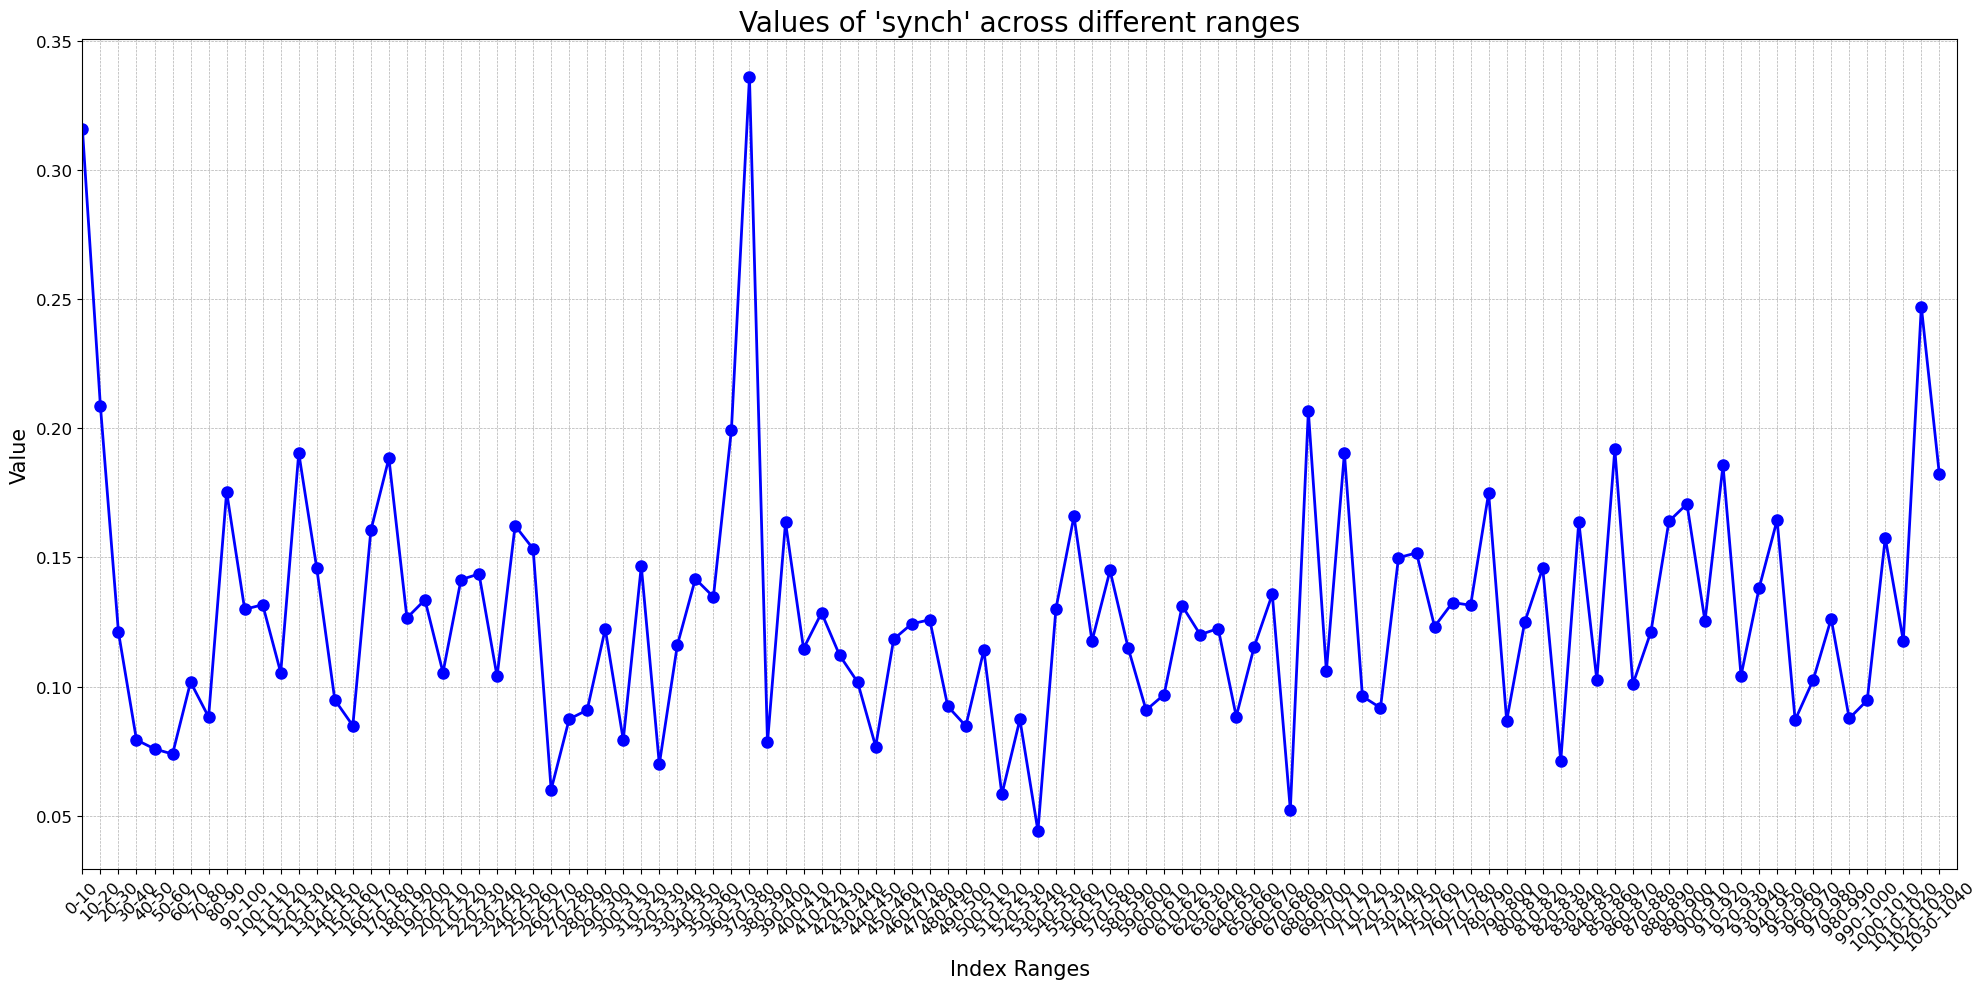

In [145]:
plot_synch(df_h2)

In [48]:
df_h8

,-103-patch,-102-patch,-101-patch,-100-patch,-99-patch,-98-patch,-97-patch,-96-patch,-95-patch,-94-patch,...,94-patch,95-patch,96-patch,97-patch,98-patch,99-patch,100-patch,101-patch,102-patch,103-patch
Segment,,,,,,,,,,,,,,,,,,,,,
0 0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<NA>
0 2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<NA>,<NA>
0 3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<NA>,<NA>,<NA>
0 4,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 99,<NA>,<NA>,<NA>,<NA>,0.0,0.0,0.0,0.0,0.0,0.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
0 100,<NA>,<NA>,<NA>,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
0 101,<NA>,<NA>,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [ ]:
#sums_counts_a,final_list_a, averages_a,sums_counts_b,final_list_b, averages_b  = calc_expected_attn_middel(a_b_dic_ordered,b_a_dic_ordered,f"Expected attention A-B","Expected attention B-A")

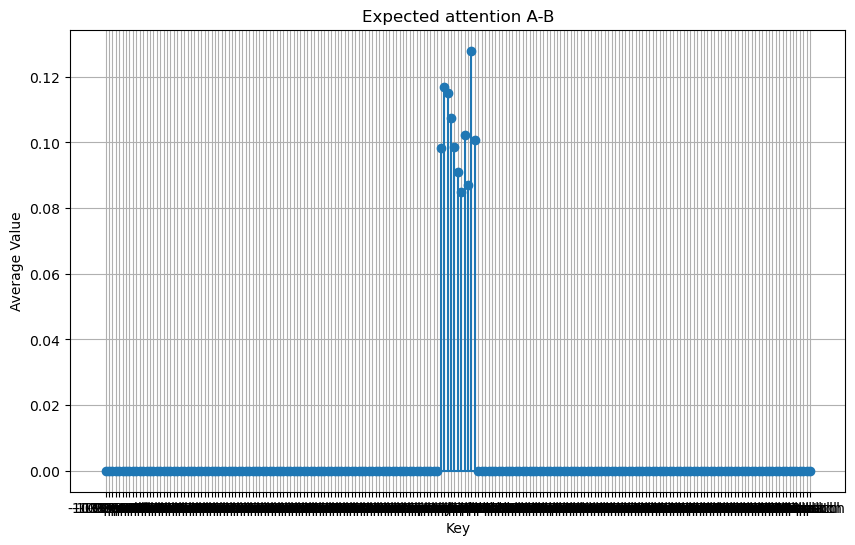

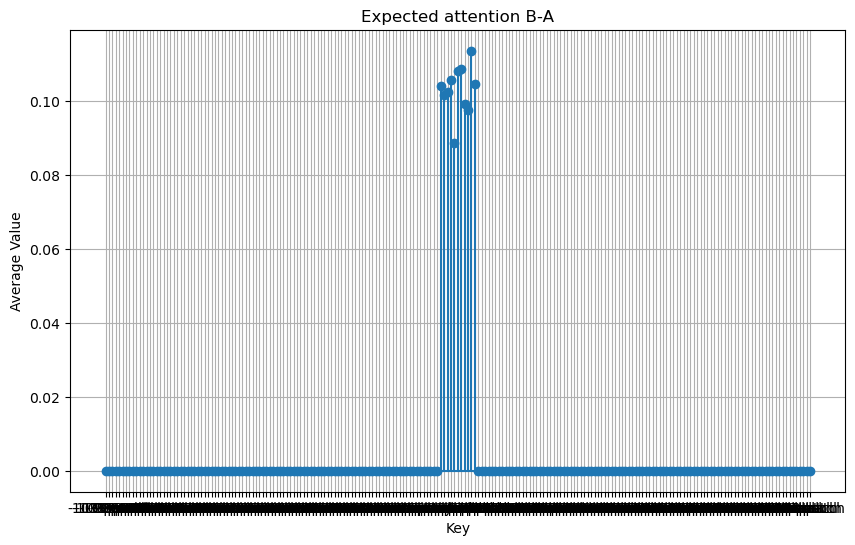

In [37]:
#sums_counts_a,final_list_a, averages_a,sums_counts_b,final_list_b, averages_b  = calc_expected_attn(a_b_dic_ordered,b_a_dic_ordered,f"Expected attention A-B","Expected attention B-A")

sums_counts_a,final_list_a, averages_a,sums_counts_b,final_list_b, averages_b  = calc_expected_attn(H4,H2,f"Expected attention A-B","Expected attention B-A")

In [100]:
averages_b

{'synch': 0.09906948428565207,
 '1-patch': 0.09505537939393549,
 '2-patch': 0.09005261771380901,
 '3-patch': 0.09069279526904372,
 '4-patch': 0.0861740261130035,
 '5-patch': 0.08635918460221904,
 '6-patch': 0.0,
 '7-patch': 0.0,
 '8-patch': 0.0,
 '9-patch': 0.0,
 '10-patch': 0.0,
 '11-patch': 0.0,
 '12-patch': 0.0,
 '13-patch': 0.0,
 '14-patch': 0.0,
 '15-patch': 0.0,
 '16-patch': 0.0,
 '17-patch': 0.0,
 '18-patch': 0.0,
 '19-patch': 0.0,
 '20-patch': 0.0,
 '21-patch': 0.0,
 '22-patch': 0.0,
 '23-patch': 0.0,
 '24-patch': 0.0,
 '25-patch': 0.0,
 '26-patch': 0.0,
 '27-patch': 0.0,
 '28-patch': 0.0,
 '29-patch': 0.0,
 '30-patch': 0.0,
 '31-patch': 0.0,
 '32-patch': 0.0,
 '33-patch': 0.0,
 '34-patch': 0.0,
 '35-patch': 0.0,
 '36-patch': 0.0,
 '37-patch': 0.0,
 '38-patch': 0.0,
 '39-patch': 0.0,
 '40-patch': 0.0,
 '41-patch': 0.0,
 '42-patch': 0.0,
 '43-patch': 0.0,
 '44-patch': 0.0,
 '45-patch': 0.0,
 '46-patch': 0.0,
 '47-patch': 0.0,
 '48-patch': 0.0,
 '49-patch': 0.0,
 '50-patch': 0.0,

In [74]:
a_b_dic_ordered_H1,a_b_dic_ordered_H2= create_attn_dicts(par_index=2,Num_head=2,THRESHOLD=0.0,tsa_layer_weights=tsa_layer_weights)

#df_a, df_b = heatmap(a_b_dic_ordered_H2,a_b_dic_ordered_H2,final_list_order,"Expected attention A-B","Expected attention B-A")
#a_b_dic_ordered_H1

ValueError: cannot select an axis to squeeze out which has size not equal to one

In [46]:
df_a = create_df(final_list_order,H1)
df_a

,-103-patch,-102-patch,-101-patch,-100-patch,-99-patch,-98-patch,-97-patch,-96-patch,-95-patch,-94-patch,...,94-patch,95-patch,96-patch,97-patch,98-patch,99-patch,100-patch,101-patch,102-patch,103-patch
Segment,,,,,,,,,,,,,,,,,,,,,
0 0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<NA>
0 2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<NA>,<NA>
0 3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<NA>,<NA>,<NA>
0 4,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 99,<NA>,<NA>,<NA>,<NA>,0.0,0.0,0.0,0.0,0.0,0.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
0 100,<NA>,<NA>,<NA>,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
0 101,<NA>,<NA>,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [45]:
print(len(final_list_order))

39


# Store for all layers

In [ ]:
#REC_4_HEAD_CROSS_1_OLD_CROSS_DEC_CROSS_BOTH_ENC9_DEC9 do Analysis here
def save_heatmap_dfs():
    model_loop = torch.load(f"crossModel/TOPS/REC_INDEPENDENT_8_HEAD_ENC9_DEC9_COMBINED.pth", map_location=torch.device('cpu'))
    tsa_layer_loop = model_loop.encoder.encode_blocks[0].encode_layers[0]
    
    tsa_layer_weights_loop = tsa_layer_loop.get_attn()
    tsa_layer_decoder_loop = model_loop.decoder.decode_layers[0].self_attention.get_attn()
    
    #FOLDER_NAME_H1 = "a_cross_cross_104_1_head"

    FOLDER_NAME_H1 = "REC_INDEPENDENT_8_HEAD_ENC9_DEC9_COMBINED/enc/a_H1"
    FOLDER_NAME_H2 = "REC_INDEPENDENT_8_HEAD_ENC9_DEC9_COMBINED/enc/a_H2"
    FOLDER_NAME_H3 = "REC_INDEPENDENT_8_HEAD_ENC9_DEC9_COMBINED/enc/a_H3"
    FOLDER_NAME_H4 = "REC_INDEPENDENT_8_HEAD_ENC9_DEC9_COMBINED/enc/a_H4"

    FOLDER_NAME_H5 = "REC_INDEPENDENT_8_HEAD_ENC9_DEC9_COMBINED/enc/a_H5"
    FOLDER_NAME_H6 = "REC_INDEPENDENT_8_HEAD_ENC9_DEC9_COMBINED/enc/a_H6"
    FOLDER_NAME_H7 = "REC_INDEPENDENT_8_HEAD_ENC9_DEC9_COMBINED/enc/a_H7"
    FOLDER_NAME_H8 = "REC_INDEPENDENT_8_HEAD_ENC9_DEC9_COMBINED/enc/a_H8" 
    
    NUM_PAIRS = 384
    for i in range(NUM_PAIRS):
        #H1,H2,H3,H4, H5,H6,H7,H8 = create_attn_dicts(par_index=i,Num_head=8,THRESHOLD=0.0,tsa_layer_weights=tsa_layer_weights_loop)
        #sums_counts_a,final_list_a, averages_a,sums_counts_b,final_list_b, averages_b  = calc_expected_attn(a_b_dic,b_a_dic_,f'heatmap_a_{i}',f'heatmap_a_{i}')
        H1,H2,H3,H4,H5, H6, H7 , H8= create_attn_dicts(par_index=i,Num_head=8,THRESHOLD=0.0,tsa_layer_weights=tsa_layer_weights_loop)

        df_h1 = create_df(final_list_order,H1)
        df_h2 = create_df(final_list_order,H2)
        df_h3 = create_df(final_list_order,H3)
        df_h4 = create_df(final_list_order,H4)

        df_h5 = create_df(final_list_order,H5)
        df_h6 = create_df(final_list_order,H6)
        df_h7 = create_df(final_list_order,H7)
        df_h8 = create_df(final_list_order,H8)

        #df_h1.to_csv(f'attn_data/exp_data/{FOLDER_NAME_H1}/heatmap_a_{i}.csv', index=False)

    
        df_h1.to_csv(f'attn_data/exp_data/TOPS/{FOLDER_NAME_H1}/heatmap_a_{i}.csv', index=False)
        df_h2.to_csv(f'attn_data/exp_data/TOPS/{FOLDER_NAME_H2}/heatmap_a_{i}.csv', index=False)
        df_h3.to_csv(f'attn_data/exp_data/TOPS/{FOLDER_NAME_H3}/heatmap_a_{i}.csv', index=False)
        df_h4.to_csv(f'attn_data/exp_data/TOPS/{FOLDER_NAME_H4}/heatmap_a_{i}.csv', index=False)
          
        df_h5.to_csv(f'attn_data/exp_data/TOPS/{FOLDER_NAME_H5}/heatmap_a_{i}.csv', index=False)
        df_h6.to_csv(f'attn_data/exp_data/TOPS/{FOLDER_NAME_H6}/heatmap_a_{i}.csv', index=False)
        df_h7.to_csv(f'attn_data/exp_data/TOPS/{FOLDER_NAME_H7}/heatmap_a_{i}.csv', index=False)
        df_h8.to_csv(f'attn_data/exp_data/TOPS/{FOLDER_NAME_H8}/heatmap_a_{i}.csv', index=False)
        
        
        #df_b.to_csv(f'attn_data/exp_data/{FOLDER_NAME}/heatmap_b_{i}.csv', index=False)
        
        # CROSS DEC TIME 208 ENC 10
    

In [42]:
save_heatmap_dfs()

In [ ]:
def save_heatmap_dfs_multi():
    NUM_PAIRS = 384
    FOLDER_NAME = "a_indp"
    for i in range(NUM_PAIRS):
        
        model_loop = torch.load(f"crossModel/BestSimple/model_pair_{i}.pth", map_location=torch.device('cpu'))
        #model = torch.load(f"crossModel/REC_REC.pth", map_location=torch.device('cpu'))
        #model = torch.load(f"crossModel/REC_AUTO_BIGGER_PATCH.pth", map_location=torch.device('cpu'))
        #model = torch.load(f"crossModel/BestPred/model_pair_{pair}.pth", map_location=torch.device('cpu'))

        tsa_layer = model_loop.encoder.encode_blocks[0].encode_layers[0]
        tsa_layer_weights_used = tsa_layer.get_attn()

        a_b_dic,b_a_dic_ = create_attn_dicts(par_index=0,Num_head=1,THRESHOLD=0.0,tsa_layer_weights=tsa_layer_weights_used)
        #sums_counts_a,final_list_a, averages_a,sums_counts_b,final_list_b, averages_b  = calc_expected_attn(a_b_dic,b_a_dic_,f'heatmap_a_{i}',f'heatmap_a_{i}')
        
        df_a, df_b = heatmap(a_b_dic,b_a_dic_,final_list_order,f'heatmap_a_{i}',f'heatmap_b_{i}')
        #df_b.to_csv(f'attn_data/heat_map_df/b/heatmap_b_{i}.csv', index=False)
        
        #df_b.to_csv(f'attn_dfs_test/dfs/heatmap_b_{i}.csv', index=False)
        df_a.to_csv(f'attn_data/exp_data/{FOLDER_NAME}/heatmap_a_{i}.csv', index=False)
        #df_b.to_csv(f'attn_data/exp_data/{FOLDER_NAME}/heatmap_b_{i}.csv', index=False)

In [ ]:
#main()
#DATASET 
#save_heatmap_dfs()

# T_SNE


In [ ]:
pair = 3
#model = torch.load(f"crossModel/BestSimple/model_pair_{pair}.pth", map_location=torch.device('cpu'))
#model = torch.load(f"crossModel/REC_REC.pth", map_location=torch.device('cpu'))
#model = torch.load(f"crossModel/REC_AUTO_BIGGER_PATCH.pth", map_location=torch.device('cpu'))
#model = torch.load(f"crossModel/BestPred/model_pair_{pair}.pth", map_location=torch.device('cpu'))
model_tsne= torch.load(f"crossModel/REC_BASE_TSA_AUTO.pth", map_location=torch.device('cpu'))
tsa_layer_tsne = model_tsne.encoder.encode_blocks[0].encode_layers[0]
tsa_layer_weights_tsne= tsa_layer_tsne.get_attn()
attens_by_pairs_tsne= organize_by_pair_index(tsa_layer_weights)

In [ ]:
def get_flatt(pair_index,attens_by_pairs_tsne,Num_head=1):
  
    choosen_pair = attens_by_pairs_tsne[pair_index] 
    choosen_pair_a_b,choosen_pair_b_a = flatten_pair(first_pair=choosen_pair)
    
    
    # extract the data in numpy
    choosen_pair_a_b = np.array(choosen_pair_a_b)
    choosen_pair_b_a = np.array(choosen_pair_b_a)

    choosen_pair_a_b = choosen_pair_a_b.squeeze(axis=1)
    choosen_pair_b_a = choosen_pair_b_a.squeeze(axis=1)
    
    return choosen_pair_a_b
    return choosen_pair_a_b.reshape(-1)
        

In [ ]:
def loop_through_paris(tsa_layer_weights_tsne):
    attens_by_pairs_tsne= organize_by_pair_index(tsa_layer_weights_tsne)
    pairs = 384
    tsne_data = np.ones((384,121))
    
    for pair in range(pairs):
        pair_mat = get_flatt(pair,attens_by_pairs_tsne)
        tsne_data[pair] = pair_mat
        
    
    return tsne_data

In [ ]:
t = loop_through_paris(tsa_layer_weights_tsne)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
t = scaler.fit_transform(t)